In [2]:
# Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
# Import Data
def load_dataset(fileName):
    allData = pd.read_csv('./' + fileName)
    return allData

In [47]:
# Clean and preprocess data
def clean_data(dataX, dataY, data_sub, vocab_size, max_len, test_size):
    # Split data into train and test data
    trainX, testX, trainY, testY = train_test_split(dataX,dataY, test_size = test_size, random_state=0)

    trainX = np.array(trainX.tolist())
    trainY = np.array(trainY.tolist())
    testX = np.array(testX.tolist())
    testY = np.array(testY.tolist())
    subX = np.array(list(data_sub))

    # Create text tokenizer
    oov_tok = "<OOV>"
    padding_type = 'post'
    trunc_type='post'
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(trainX)
    word_index = tokenizer.word_index

    # pads each sentence - all have to be same length for neural network input
    train_sequences = tokenizer.texts_to_sequences(trainX)
    train_padded = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    test_sequences = tokenizer.texts_to_sequences(testX)
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating = trunc_type)

    sub_sequences = tokenizer.texts_to_sequences(subX)
    sub_padded = pad_sequences(sub_sequences, maxlen=max_len, padding=padding_type, truncating = trunc_type)


    trainY = pd.get_dummies(trainY).values
    testY = pd.get_dummies(testY).values


    return train_padded, test_padded, trainY, testY, sub_padded
    

In [5]:
def define_model_tensorflow(vocab_size, max_length):
    embedding_dim = 300
    model = Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(21, activation='softmax')
    ])

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# model evaluation
def evaluate_model(model, train_padded, trainY, test_padded, testY, num_epochs):
    verbose = 1
    scores, histories = list(), list()

    history = model.fit(train_padded, trainY, epochs=num_epochs, validation_data=(test_padded,testY), verbose = verbose)
    # evaluate model performance
    _, acc = model.evaluate(test_padded, testY, verbose=1)
    print ('> %.3f' % (acc * 100.0))

    scores.append(acc)
    histories.append(history)

    return scores, histories


In [7]:
# present results
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        #plot loss 
        plt.subplot(2,1,1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.legend()
        # plot accuracy
        plt.subplot(2,1,2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.legend()
    plt.show()

In [51]:
# Load in Data
allData = load_dataset('train.csv')
data_sub = load_dataset('test.csv')
# data_sub = load_dataset('train.csv')
# data_sub = data_sub[:2000]
# allData['categories'].value_counts().plot(kind='bar', figsize=(14,5))

# set model parameters
vocab_size = 5000 # max vocab size
max_len = 40 # sequenece length to pad the outputs to

# Clean/preprocess data
allData_x = allData['title'] + ' ' + allData['description']
data_sub_x = data_sub['title'] + ' ' + data_sub['description']

train_padded, test_padded, trainY, testY, sub_padded = clean_data(allData_x, allData['categories'], data_sub_x, vocab_size, max_len, test_size = 0.3)



In [30]:
model = define_model_tensorflow(vocab_size, max_len)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 300)           1500000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 40, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 200)              

In [31]:
scores, histories = evaluate_model(model, train_padded, trainY, test_padded, testY, num_epochs = 10)

Epoch 1/10
1012/1012 [==============================] - 240s 230ms/step - loss: 1.8182 - accuracy: 0.4331 - val_loss: 1.3183 - val_accuracy: 0.5987
Epoch 2/10
1012/1012 [==============================] - 171s 169ms/step - loss: 1.1067 - accuracy: 0.6623 - val_loss: 1.0994 - val_accuracy: 0.6700
Epoch 3/10
1012/1012 [==============================] - 147s 145ms/step - loss: 0.9109 - accuracy: 0.7258 - val_loss: 1.0812 - val_accuracy: 0.6894
Epoch 4/10
1012/1012 [==============================] - 139s 138ms/step - loss: 0.7758 - accuracy: 0.7693 - val_loss: 1.0853 - val_accuracy: 0.6936
Epoch 5/10
1012/1012 [==============================] - 141s 139ms/step - loss: 0.6721 - accuracy: 0.8008 - val_loss: 1.0870 - val_accuracy: 0.7068
Epoch 6/10
1012/1012 [==============================] - 147s 146ms/step - loss: 0.5936 - accuracy: 0.8227 - val_loss: 1.1209 - val_accuracy: 0.7074
Epoch 7/10
1012/1012 [==============================] - 158s 156ms/step - loss: 0.5161 - accuracy: 0.8470 - val_

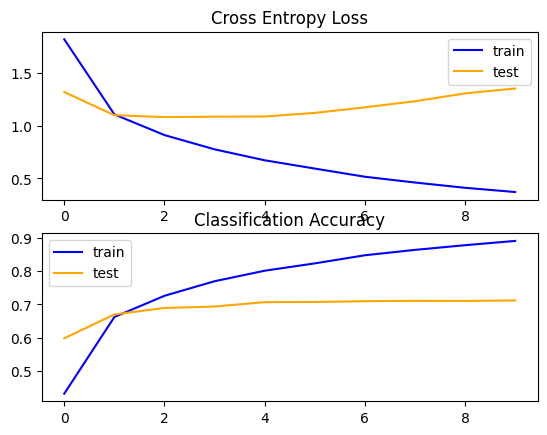

In [32]:
summarize_diagnostics(histories)

434/434 [==============================] - 7s 16ms/step


Text(0.5, 135.7222222222222, 'Predicted label')

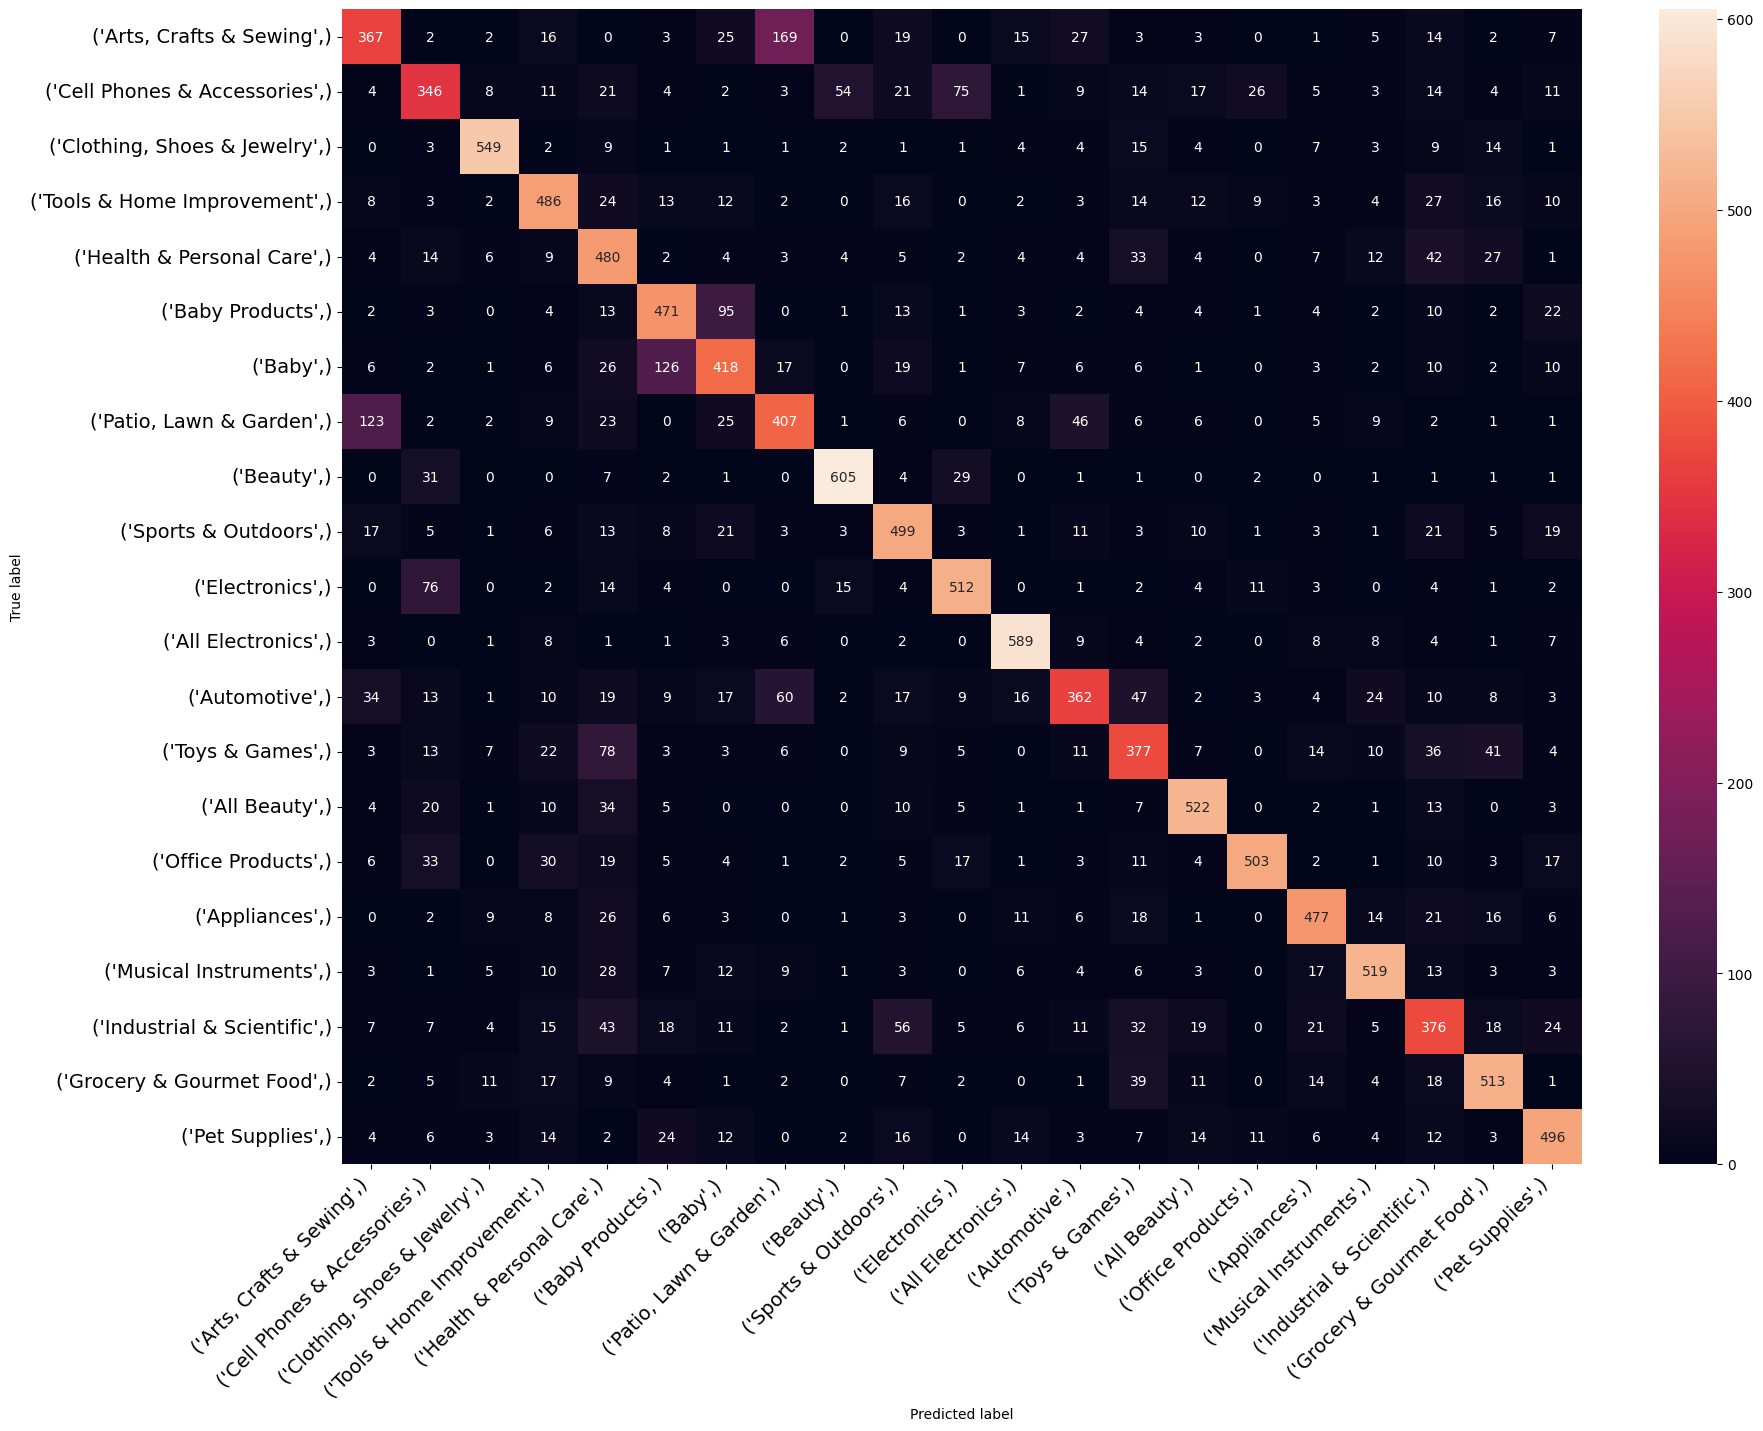

In [33]:
# Plot test data confusion Matrix
predictions = model.predict(test_padded, verbose=1)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(testY, axis = 1)

cm = confusion_matrix(y_test, classes)

all_cat = pd.DataFrame(allData['categories']).drop_duplicates(ignore_index=True)

df_cm = pd.DataFrame(cm, index=all_cat, columns=all_cat)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [52]:
# Check test data
pred = model.predict(sub_padded, verbose = 1)
test_classes = np.argmax(pred, axis = 1)

63/63 [==============================] - 1s 21ms/step


In [55]:
# Create submission file - test results
results_df = data_sub.assign(categories_id=test_classes)
all_cat['categories_id'] = all_cat.index
# results_df = pd.merge(results_df, all_cat, how='left', on=['categories_id'])

results_df.to_csv('submission.csv')

    
